In [15]:
from qiskit_experiments.library import CrossResonanceHamiltonian
import numpy as np
import pandas as pd
from qiskit_experiments.calibration_management.calibrations import Calibrations
from qiskit_experiments.calibration_management.basis_gate_library import FixedFrequencyTransmon
from qiskit_dynamics import DynamicsBackend
from qiskit_dynamics import Solver
import numpy as np
from qiskit.circuit.library import HGate
from qiskit.transpiler import InstructionProperties
import jax
from qiskit import pulse
from qiskit import QuantumCircuit

jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")

In [16]:
dim = 3

v0 = 4.86e9
anharm0 = -0.32e9
r0 = 0.22e9

v1 = 4.97e9
anharm1 = -0.32e9
r1 = 0.26e9

J = 0.002e9

a = np.diag(np.sqrt(np.arange(1, dim)), 1)
adag = np.diag(np.sqrt(np.arange(1, dim)), -1)
N = np.diag(np.arange(dim))

ident = np.eye(dim, dtype=complex)
full_ident = np.eye(dim**2, dtype=complex)

N0 = np.kron(ident, N)
N1 = np.kron(N, ident)

a0 = np.kron(ident, a)
a1 = np.kron(a, ident)

a0dag = np.kron(ident, adag)
a1dag = np.kron(adag, ident)


static_ham0 = 2 * np.pi * v0 * N0 + np.pi * anharm0 * N0 * (N0 - full_ident)
static_ham1 = 2 * np.pi * v1 * N1 + np.pi * anharm1 * N1 * (N1 - full_ident)

static_ham_full = static_ham0 + static_ham1 + 2 * np.pi * J * ((a0 + a0dag) @ (a1 + a1dag))

drive_op0 = 2 * np.pi * r0 * (a0 + a0dag)
drive_op1 = 2 * np.pi * r1 * (a1 + a1dag)

In [17]:
dt = 1/4.5e9

solver = Solver(
    static_hamiltonian=static_ham_full,
    hamiltonian_operators=[drive_op0, drive_op1, drive_op0, drive_op1],
    rotating_frame=static_ham_full,
    hamiltonian_channels=["d0", "d1", "u0", "u1"],
    channel_carrier_freqs={"d0": v0, "d1": v1, "u0": v1, "u1": v0},
    dt=dt,
    array_library="jax",
)

In [18]:
from qiskit_dynamics import DynamicsBackend

# Consistent solver option to use throughout notebook
solver_options = {"method": "jax_odeint", "atol": 1e-6, "rtol": 1e-8, "hmax": dt}

backend = DynamicsBackend(
    solver=solver,
    subsystem_dims=[dim, dim], # for computing measurement data
    solver_options=solver_options, # to be used every time run is called
)

In [19]:
from qiskit.circuit.library import XGate, SXGate, RZGate, CXGate
from qiskit.circuit import Parameter
from qiskit.providers.backend import QubitProperties
target = backend.target

# qubit properties
target.qubit_properties = [QubitProperties(frequency=v0), QubitProperties(frequency=v1)]

# add instructions
target.add_instruction(XGate(), properties={(0,): None, (1,): None})
target.add_instruction(SXGate(), properties={(0,): None, (1,): None})

target.add_instruction(CXGate(), properties={(0, 1): None, (1, 0): None})

# Add RZ instruction as phase shift for drag cal
phi = Parameter("phi")
with pulse.build() as rz0:
    pulse.shift_phase(phi, pulse.DriveChannel(0))
    pulse.shift_phase(phi, pulse.ControlChannel(1))

with pulse.build() as rz1:
    pulse.shift_phase(phi, pulse.DriveChannel(1))
    pulse.shift_phase(phi, pulse.ControlChannel(0))

target.add_instruction(
    RZGate(phi),
    {(0,): InstructionProperties(calibration=rz0), (1,): InstructionProperties(calibration=rz1)}
)

In [20]:
cals = Calibrations(libraries=[FixedFrequencyTransmon(basis_gates=['x', 'sx'])])

pd.DataFrame(**cals.parameters_table(qubit_list=[0, ()]))

,parameter,qubits,schedule,value,group,valid,date_time,exp_id
0,amp,(),x,0.50,default,True,2024-04-13 15:11:57.601490+0200,None
1,amp,(),sx,0.25,default,True,2024-04-13 15:11:57.601490+0200,None
2,σ,(),x,40.00,default,True,2024-04-13 15:11:57.601490+0200,None
3,duration,(),x,160.00,default,True,2024-04-13 15:11:57.601490+0200,None
4,β,(),x,0.00,default,True,2024-04-13 15:11:57.601490+0200,None
5,σ,(),sx,40.00,default,True,2024-04-13 15:11:57.601490+0200,None
6,duration,(),sx,160.00,default,True,2024-04-13 15:11:57.601490+0200,None
7,β,(),sx,0.00,default,True,2024-04-13 15:11:57.601490+0200,None
8,angle,(),x,0.00,default,True,2024-04-13 15:11:57.601490+0200,None
9,angle,(),sx,0.00,default,True,2024-04-13 15:11:57.601490+0200,None


In [21]:
from qiskit_experiments.library.calibration import RoughXSXAmplitudeCal

# rabi experiments for qubit 0
rabi0 = RoughXSXAmplitudeCal([0], cals, backend=backend, amplitudes=np.linspace(-0.2, 0.2, 27))

# rabi experiments for qubit 1
rabi1 = RoughXSXAmplitudeCal([1], cals, backend=backend, amplitudes=np.linspace(-0.2, 0.2, 27))

In [22]:
rabi0_data = rabi0.run().block_for_results()
rabi1_data = rabi1.run().block_for_results()

In [23]:
# rabi0_data.figure(0)


In [24]:
# from qiskit_experiments.library.calibration import RoughDragCal

# cal_drag0 = RoughDragCal([0], cals, backend=backend, betas=np.linspace(-20, 20, 15))
# cal_drag1 = RoughDragCal([1], cals, backend=backend, betas=np.linspace(-20, 20, 15))

# cal_drag0.set_experiment_options(reps=[3, 5, 7])
# cal_drag1.set_experiment_options(reps=[3, 5, 7])

# cal_drag0.circuits()[5].draw(output="mpl")

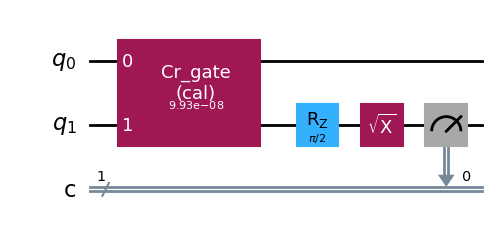

In [25]:
backend.set_options(control_channel_map={(0, 1): 0, (1, 0): 1})
cr_ham_experiment = CrossResonanceHamiltonian(
    physical_qubits=(0, 1),
    durations=np.linspace(1e-7, 1e-6, 17),
    backend=backend
)

backend.target.update_from_instruction_schedule_map(cals.get_inst_map())
cr_ham_experiment.circuits()[6].draw("mpl")

In [26]:
len(cr_ham_experiment.circuits())

102

In [27]:
%time data_cr = cr_ham_experiment.run().block_for_results()


CPU times: total: 8.77 s
Wall time: 11.2 s


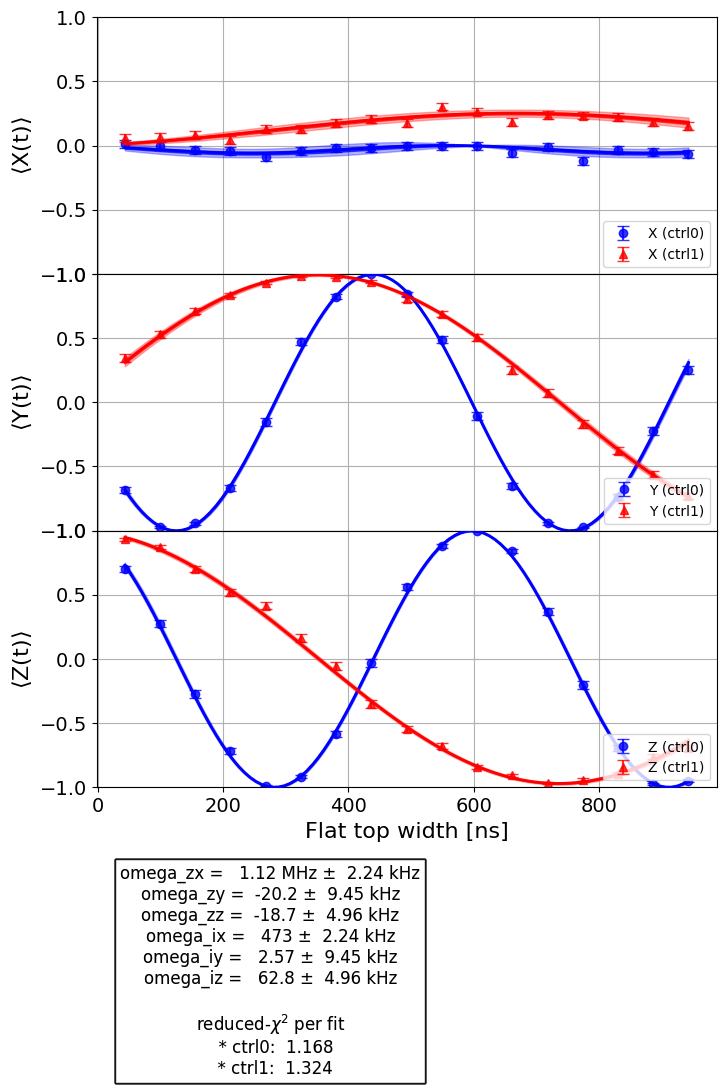

In [28]:
data_cr.figure(0)
